In [11]:
import numpy as np
import scipy
from scipy.fftpack import dct, idct
from PIL import Image
import matplotlib.pyplot as plt
from load_cifar import load_cifar_10_data

def DCT(image):
    return dct(dct(image, norm="ortho", axis=0), norm="ortho", axis=1)

def iDCT(image):
    return idct(idct(image, norm="ortho", axis=0), norm="ortho", axis=1)

def FFT(image, spectrum=True):
    ftimage = np.fft.fft2(image, axes=(0, 1))
#     ftimage = np.fft.fftshift(ftimage, axes=(0, 1))
    if spectrum:
        ftimage = np.abs(ftimage)
    return ftimage

def iFFT(ftimage):
#     ftimage = ftimage = np.fft.ifftshift(ftimage, axes=(0, 1))
    image = np.abs(np.fft.fft2(ftimage, axes=(0, 1)))
    image /= np.max(image, axis=(0, 1))
    return image
    

In [7]:
cifar_10_dir = 'data/cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

In [8]:
image = train_data[1]

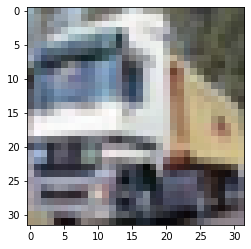

In [9]:
plt.imshow(image)
plt.show()

In [205]:
freq = FFT(image)
# freq= np.fft.fft2(image[:, :, 2])
# freq = np.fft.fftshift(freq)
# freq = np.abs(freq)
print(freq.shape)

(32, 32, 3)


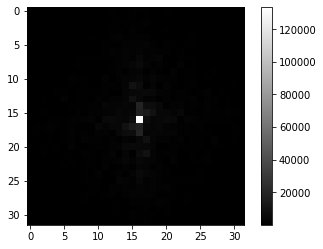

In [206]:
plt.imshow(freq[:, :, 0], cmap='gray')
plt.colorbar()
plt.show()

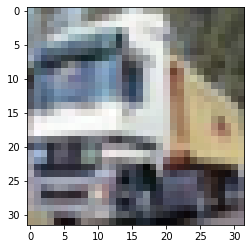

In [12]:
# freq = FFT(image, spectrum=False)
image = iFFT(FFT(image, spectrum=False))
plt.imshow(image)

In [219]:
def masking(image, mode='n', stride=1):
    dctSize = image.shape[0]
    dof = []
    dof_image = []
    for i in range(dctSize):
        freq_image = DCT(image.copy())
        if i > stride-1:
            if mode == 'n':
                mask = np.ones_like(freq_image)
                mask[i-stride:i, :i] = 0
                mask[:i, i-stride:i] = 0
            elif mode == 's':
                mask = np.zeros_like(freq_image)
                mask[i-stride:i, :i] = 1
                mask[:i, i-stride:i] = 1
            freq_image *= mask
        dof.append(freq_image)
        dof_image.append(iDCT(freq_image)/255.)
    return np.array(dof), np.array(dof_image)

def fft_masking(image, mode='n', tol=0.2):
    dctSize = image.shape[0] // 2
    cx = image.shape[0] // 2
    cy = image.shape[0] // 2
    dof = []
    dof_image = []
    for i in range(dctSize):
        freq_image = FFT(image.copy(), spectrum=False)
        if i > 0:
            if mode == 'n':
                mask = np.ones_like(freq_image)
                for x in range(image.shape[0]):
                    for y in range(image.shape[0]):
                        if np.abs(np.sqrt((x-cx)**2 + (y-cy)**2) - i) <= tol:
                            mask[x, y] = 0
                # mask[i-stride:i, :i] = 0
                # mask[:i, i-stride:i] = 0
            elif mode == 's':
                mask = np.zeros_like(freq_image)
                for x in range(image.shape[0]):
                    for y in range(image.shape[0]):
                        if np.sqrt((x-cx)**2 + (y-cy)**2) - i <= tol:
                            mask[x, y] = 1
            freq_image *= mask
        dof.append(freq_image)
        dof_image.append(iFFT(freq_image))
    return np.array(dof), np.array(dof_image)


In [225]:
dof, dof_image = fft_masking(image, mode='n', tol=0.2)
np.save("Ndof_fft.npy", dof)
np.save("Ndof_image_fft.npy", dof_image)


In [72]:
dof, dof_image = masking(image, mode='s')
np.save("Sdof.npy", dof)
np.save("Sdof_image.npy", dof_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


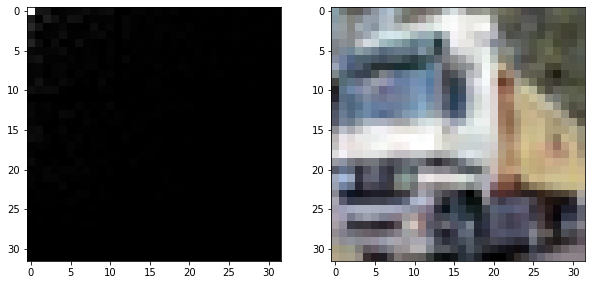

In [10]:
dof = np.load("Ndof.npy")
dof_image = np.load("Ndof_image.npy")

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.abs(dof[12]).mean(axis=-1), cmap='gray')
ax[1].imshow(dof_image[12])


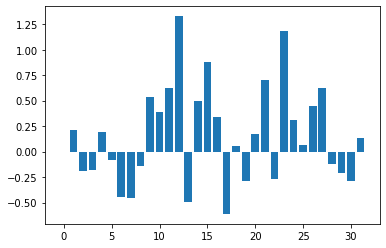

In [3]:
freq_attr = np.load("N_freq_attr.npy")
plt.bar(np.arange(len(freq_attr)), height=freq_attr)
plt.show()

In [4]:
attr = np.load("N_freq_attr_train.npy")
labels = np.load("N_freq_attr_train_labels.npy")
attr.shape

(50000, 32)

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def barplot(i):
    test_attr = attr[i]
    test_label = labels[i]
    plt.bar(np.arange(test_attr.shape[0]), height=test_attr, color=['blue' if l == 0 else 'red' for l in test_label])

interact(barplot, i=widgets.IntSlider(min=0, max=attr.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=50000), Output()), _dom_classes=('widget-interac…

<function __main__.barplot(i)>

### Expectation of Attribution

<BarContainer object of 32 artists>

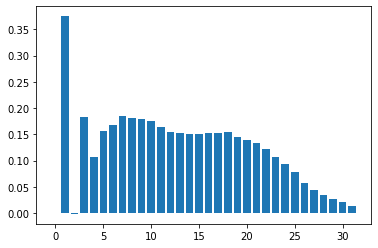

In [4]:
plt.bar(np.arange(attr.shape[1]), height=attr.mean(axis=0))

### Normalized Expectation for positive attribution

<BarContainer object of 32 artists>

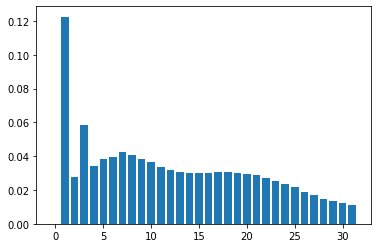

In [27]:
pos_attr = np.maximum(np.zeros_like(attr), attr) + 1e-16
pos_attr /= np.sum(pos_attr, axis=-1, keepdims=True)
plt.bar(np.arange(attr.shape[1]), height=pos_attr.mean(axis=0))

### Normalized Expectation for negative attribution

<BarContainer object of 32 artists>

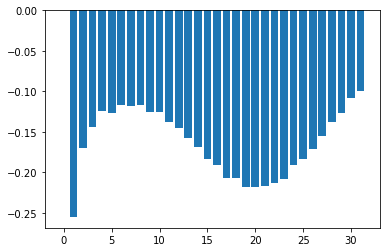

In [10]:
neg_attr = np.minimum(np.zeros_like(attr), attr)
# pos_attr = pos_attr / np.max(pos_attr, axis=1, keepdims=True)
plt.bar(np.arange(attr.shape[1]), height=neg_attr.mean(axis=0))